In [1]:
!pwd
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

/content


In [2]:
! chmod 600 kaggle.json
! kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
! unzip -qq /content/ham1000-segmentation-and-classification.zip

100% 2.59G/2.59G [02:21<00:00, 17.8MB/s]
100% 2.59G/2.59G [02:21<00:00, 19.6MB/s]


In [3]:
!pip install vit_keras
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.6 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
import warnings
from PIL import Image
import keras
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.15.0


# EDA

In [2]:
df_labels = pd.read_csv('../content/GroundTruth.csv')
df_labels['image'] = df_labels['image'] +'.jpg'

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df_labels)):
    row= list(df_labels.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df_labels['label']= label_list
df_labels=df_labels.drop(labels, axis=1)
df_labels['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [3]:
df_labels.head()

image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL

## Load Images

In [ ]:
sdir=r'../content/images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=224  # image height
width=224   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)

def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet

df_gen=gen.flow_from_dataframe( df_labels, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 10015 validated image filenames belonging to 7 classes.


In [ ]:
def show_image_samples(gen):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

## Display Image

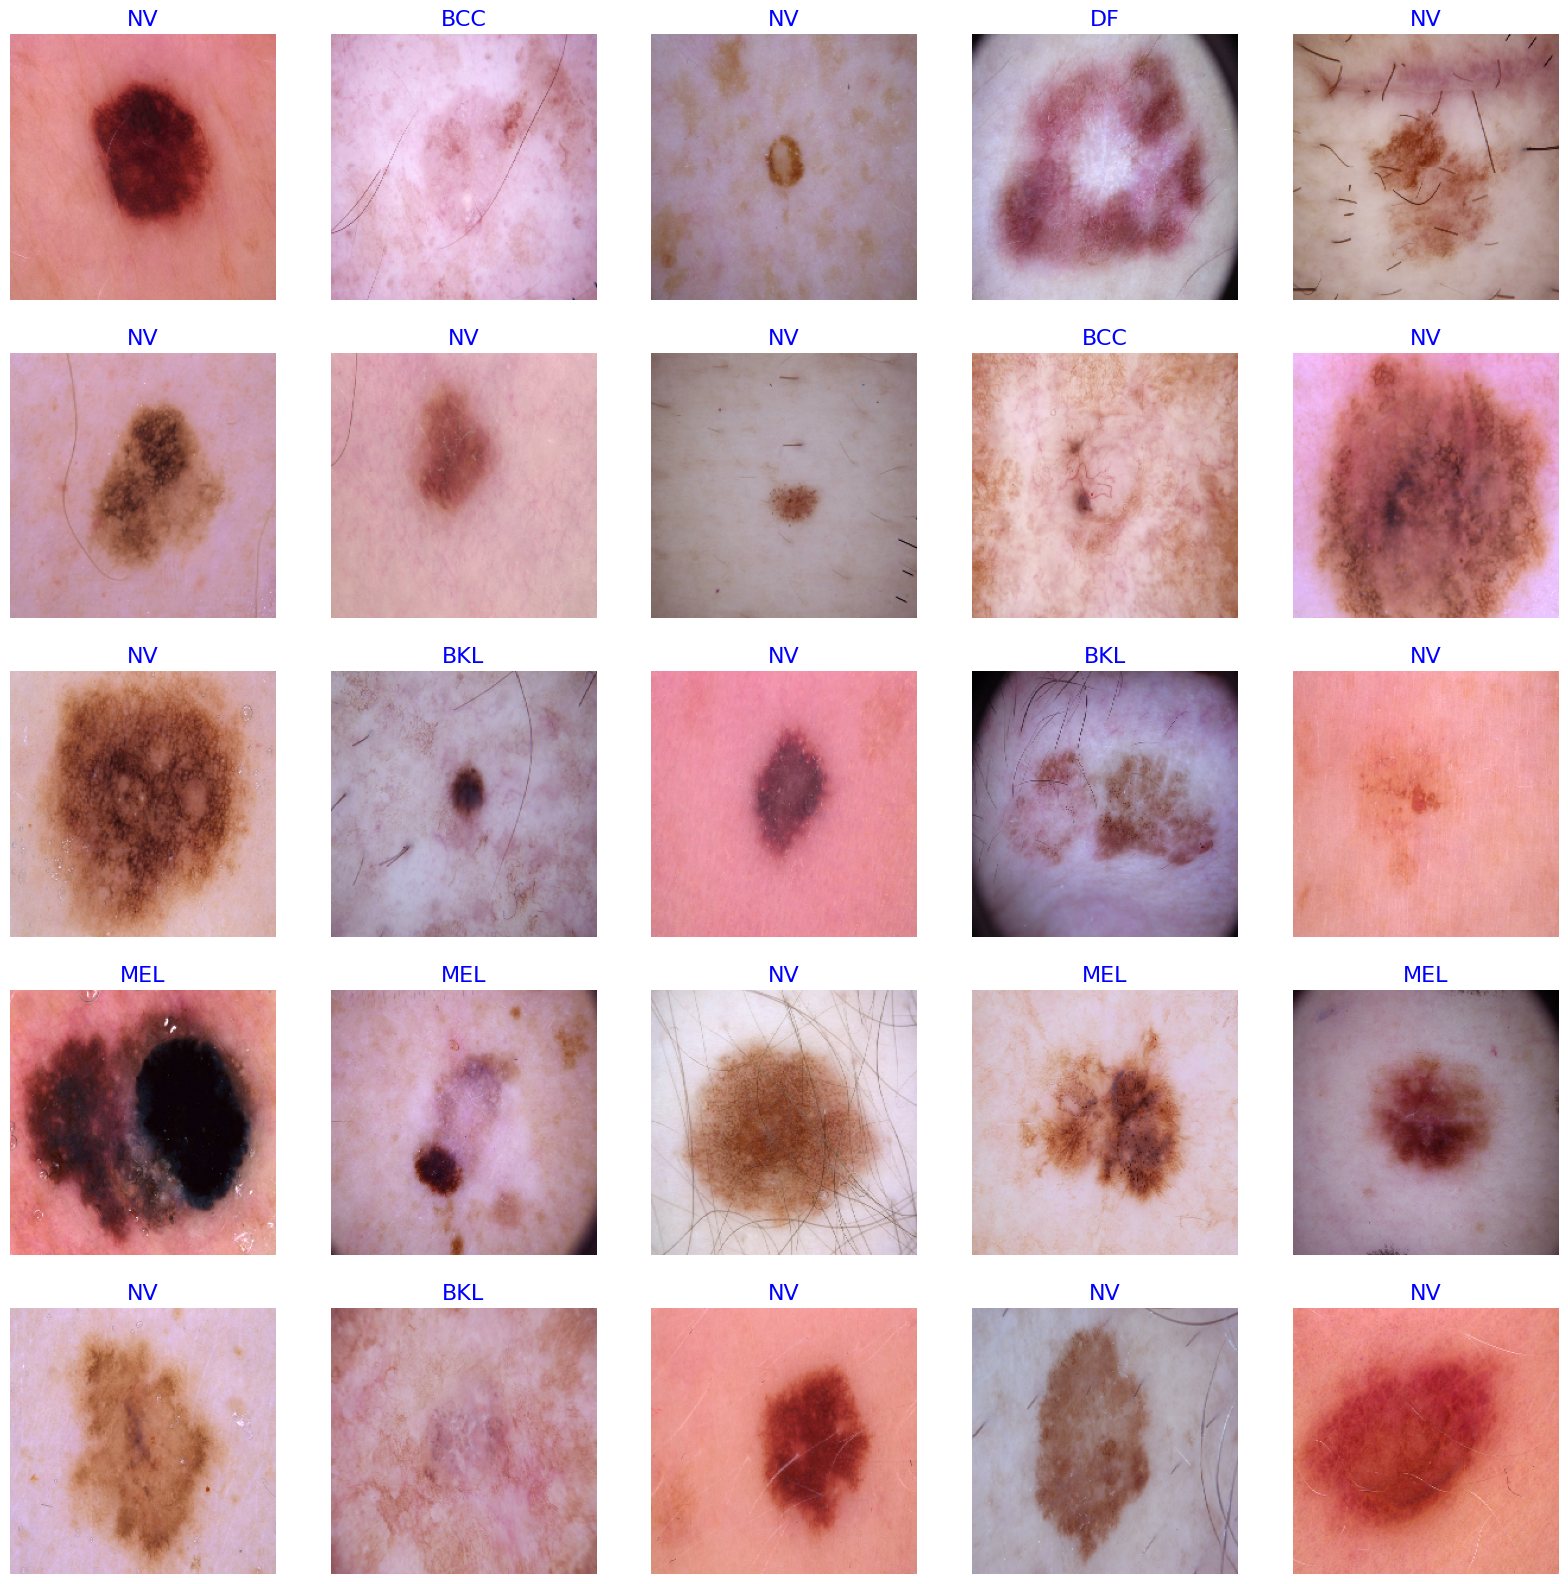

In [ ]:
show_image_samples(df_gen)

# Image Processing

In [4]:
image_size = 224
batch_size = 16
n_classes = 7
EPOCHS = 5

train_path = '../content/images'

classes = {0 : "NV",
           1 : "MEL",
           2 : "BKL",
           3 : "BCC",
           4 : "AKIEC",
           5 : "VASC",
           6 : "DF"}

## Data Augmentations

In [5]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    # if p_pixel_2 >= .4:
    #     image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image

## Image Generator

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)
# set as training data

train_gen  = datagen.flow_from_dataframe(
    df_labels,
    train_path,
    x_col='image',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training')

# same directory as training data

valid_gen  = datagen.flow_from_dataframe(
    df_labels,
    train_path ,
    x_col='image',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [7]:
class_weight = {5: 6705.0/6705, 4: 6705.0/1113, 2: 6705.0/1099, 1: 6705.0/514, 0: 6705.0/327, 6: 6705.0/142, 3: 6705.0/115}

# ViT Model

## Implement patch creation as a layer

In [8]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

## Build Model

In [9]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)

In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

## Training The Model

In [11]:
model.load_weights('model_weight.h5')

In [12]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          class_weight = class_weight,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)
model.save_weights('model_weight.h5')

Epoch 1/5
500/500 [==============================] - 618s 1s/step - loss: 4.0635 - accuracy: 0.9090 - val_loss: 1.0512 - val_accuracy: 0.8590
Epoch 2/5
500/500 [==============================] - 590s 1s/step - loss: 3.7583 - accuracy: 0.9576 - val_loss: 1.0879 - val_accuracy: 0.8450
Epoch 3/5
500/500 [==============================] - 590s 1s/step - loss: 3.7875 - accuracy: 0.9577 - val_loss: 1.1330 - val_accuracy: 0.8210
Epoch 4/5
500/500 [==============================] - 590s 1s/step - loss: 4.1085 - accuracy: 0.9193 - val_loss: 1.1223 - val_accuracy: 0.8225
Epoch 5/5
500/500 [==============================] - 591s 1s/step - loss: 3.9241 - accuracy: 0.9308 - val_loss: 1.1285 - val_accuracy: 0.8170


In [13]:
model.save_weights('model_weight.h5')

## Model Result

In [13]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)

126/126 [==============================] - 74s 564ms/step


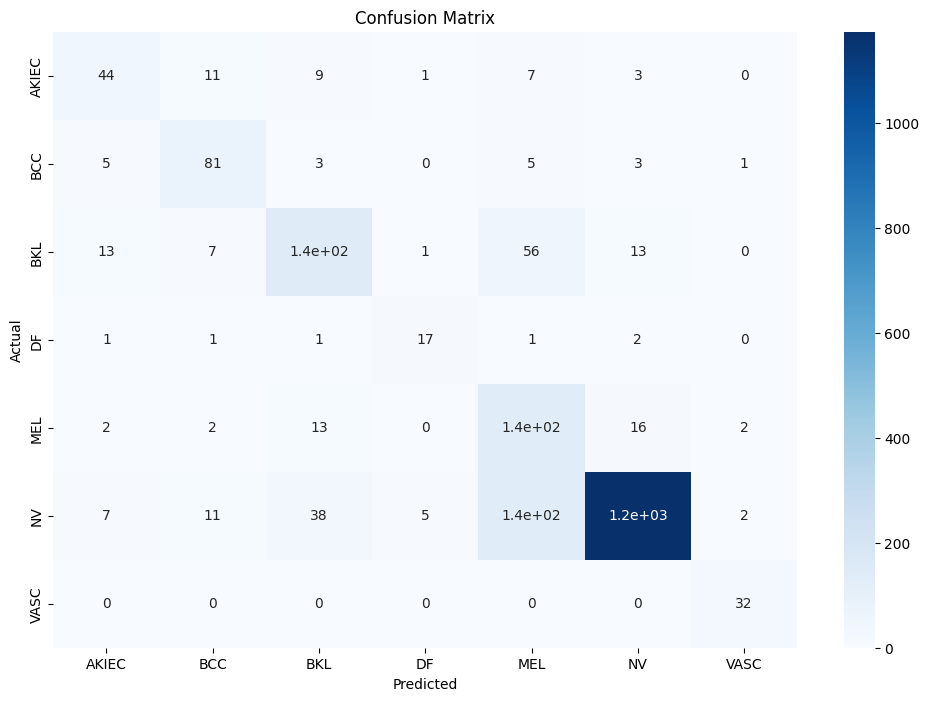

In [14]:
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (12, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# displaying the title
plt.title("Confusion Matrix")

plt.show()

In [15]:
print("Classification Report:")
print("=====================================================")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.61      0.59      0.60        75
         BCC       0.72      0.83      0.77        98
         BKL       0.68      0.61      0.64       229
          DF       0.71      0.74      0.72        23
         MEL       0.40      0.80      0.53       172
          NV       0.97      0.85      0.91      1374
        VASC       0.86      1.00      0.93        32

    accuracy                           0.81      2003
   macro avg       0.71      0.77      0.73      2003
weighted avg       0.86      0.81      0.83      2003



# ResNet50

## Build Model

In [8]:
model2 = tf.keras.Sequential()

base1= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')

model2.add(base1)

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dense(7, 'softmax'))

for layer in base1.layers:
    layer.trainable = False

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                8

## Training The Model

In [9]:
model2.load_weights('model_weight2.h5')

In [10]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model2.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

history = model2.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          class_weight = class_weight,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)
model2.save_weights('model_weight2.h5')

Epoch 1/5
500/500 [==============================] - 267s 520ms/step - loss: 5.5343 - accuracy: 0.6600 - val_loss: 1.4492 - val_accuracy: 0.6115
Epoch 2/5
500/500 [==============================] - 258s 516ms/step - loss: 4.9707 - accuracy: 0.6966 - val_loss: 1.4476 - val_accuracy: 0.6175
Epoch 3/5
500/500 [==============================] - 257s 514ms/step - loss: 4.7174 - accuracy: 0.7356 - val_loss: 1.4426 - val_accuracy: 0.6180
Epoch 4/5
500/500 [==============================] - 256s 511ms/step - loss: 4.5914 - accuracy: 0.7530 - val_loss: 1.4272 - val_accuracy: 0.6265
Epoch 5/5
500/500 [==============================] - 256s 511ms/step - loss: 4.4908 - accuracy: 0.7741 - val_loss: 1.4091 - val_accuracy: 0.6265


## Model Result

In [11]:
predicted_classes = np.argmax(model2.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)

126/126 [==============================] - 51s 402ms/step


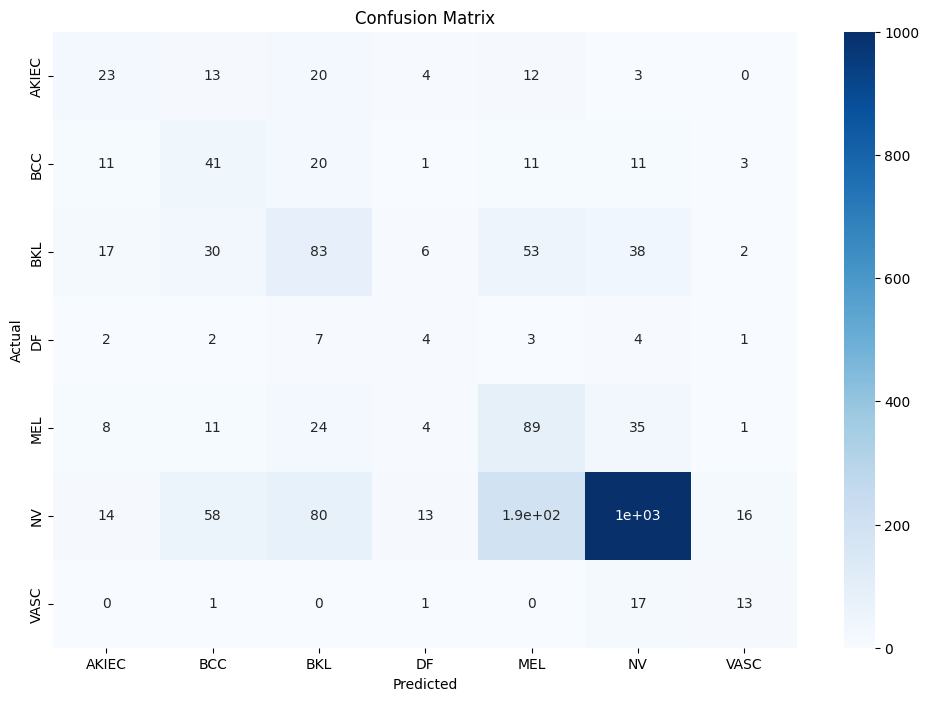

In [12]:
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (12, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# displaying the title
plt.title("Confusion Matrix")

plt.show()

In [13]:
print("Classification Report:")
print("=====================================================")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.31      0.31      0.31        75
         BCC       0.26      0.42      0.32        98
         BKL       0.35      0.36      0.36       229
          DF       0.12      0.17      0.14        23
         MEL       0.25      0.52      0.33       172
          NV       0.90      0.73      0.81      1374
        VASC       0.36      0.41      0.38        32

    accuracy                           0.63      2003
   macro avg       0.37      0.42      0.38      2003
weighted avg       0.71      0.63      0.66      2003

